# Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Set all the constants

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

# Import data menjadi tensorflow dataset object

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "cataract-dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE), 
    batch_size = BATCH_SIZE
)

Found 610 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['cataract', 'normal']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1]


# Visualize some images from the dataset

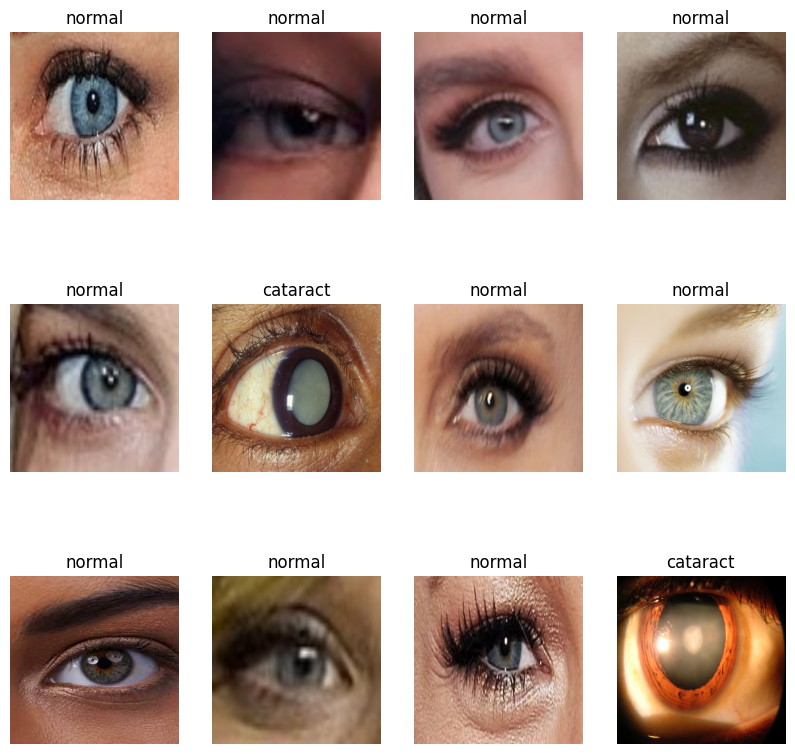

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Function to split the dataset

Dataset dibagi menjadi 3 subset, yaitu :

1. Training : digunakan untuk training.
2. Validation : digunakan untuk ditest saat proses training
3. Test : digunakan untuk testing dataset dengan model yang telah di train

In [7]:
len(dataset)

20

In [8]:
train_size = 0.8
len(dataset)*train_size

16.0

In [9]:
train_ds = dataset.take(16)
len(train_ds)

16

In [10]:
test_ds = dataset.skip(16)
len(test_ds)

4

In [11]:
val_size = 0.1
len(dataset)*val_size

2.0

In [12]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [13]:
test_ds = test_ds.skip(2)
len(test_ds)

2

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

16

In [17]:
len(val_ds)

2

In [18]:
len(test_ds)

2

# Cache, Shuffle, and Prefetch the dataset

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Membuat model

### Membuat layer untuk resizing dan normalization

untuk improve performa dari model, kita harus normalize pixel dari gambarnya terlebih dahulu (pada range 0 dan 1 yang dibagi oleh 256). resizing image akan sangat membantu ketika menggunakan model untuk prediksi, jadi ketika seseorang memasukkan inputan gambar yang bukan berukuran 256 maka layer ini akan me-resize gambar tersebut.

In [20]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation

data augmentation dibutuhkan ketika kita memiliki less data, this will boosts akurasi dari model kita dengan meng-augmentating data nya.

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Architecture

menggunakan CNN dengan softmax activation

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

# Compiling the model

dengan menggunakan adam optimizer, sparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
16/16 [==============================] - 22s 1s/step - loss: 0.7946 - accuracy: 0.5249 - val_loss: 0.7128 - val_accuracy: 0.5469
Epoch 2/50
16/16 [==============================] - 14s 852ms/step - loss: 0.7006 - accuracy: 0.5498 - val_loss: 0.6458 - val_accuracy: 0.5938
Epoch 3/50
16/16 [==============================] - 13s 820ms/step - loss: 0.6439 - accuracy: 0.6349 - val_loss: 0.6622 - val_accuracy: 0.5938
Epoch 4/50
16/16 [==============================] - 13s 825ms/step - loss: 0.6332 - accuracy: 0.6369 - val_loss: 0.4801 - val_accuracy: 0.7969
Epoch 5/50
16/16 [==============================] - 13s 812ms/step - loss: 0.4445 - accuracy: 0.7905 - val_loss: 0.3982 - val_accuracy: 0.8438
Epoch 6/50
16/16 [==============================] - 13s 815ms/step - loss: 0.3729 - accuracy: 0.8340 - val_loss: 0.2874 - val_accuracy: 0.9062
Epoch 7/50
16/16 [==============================] - 13s 820ms/step - loss: 0.2672 - accuracy: 0.8859 - val_loss: 0.2669 - val_accuracy: 0.8750
Ep

In [28]:
results = model.evaluate(test_ds, verbose=1)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

2/2 [==============================] - 4s 19ms/step - loss: 6.5452e-04 - accuracy: 1.0000
    Test Loss: 0.00065
Test Accuracy: 100.00%


In [29]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 20ms/step - loss: 6.5452e-04 - accuracy: 1.0000


In [30]:
scores

[0.0006545197684317827, 1.0]

# Plotting the accuracy and loss curves

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 16}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.7945562601089478,
 0.700624942779541,
 0.6438604593276978,
 0.6332119703292847,
 0.4445226192474365]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

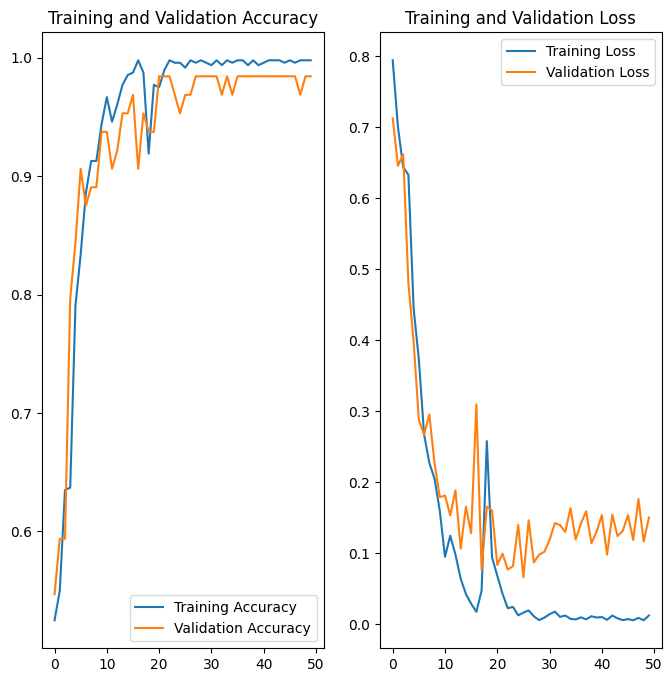

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run prediction on sample image

first image to predict
actual label: normal
predicted label: normal


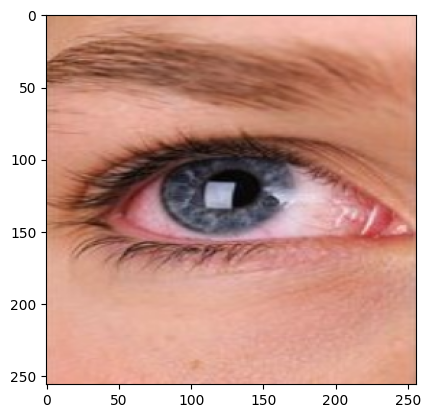

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
# write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

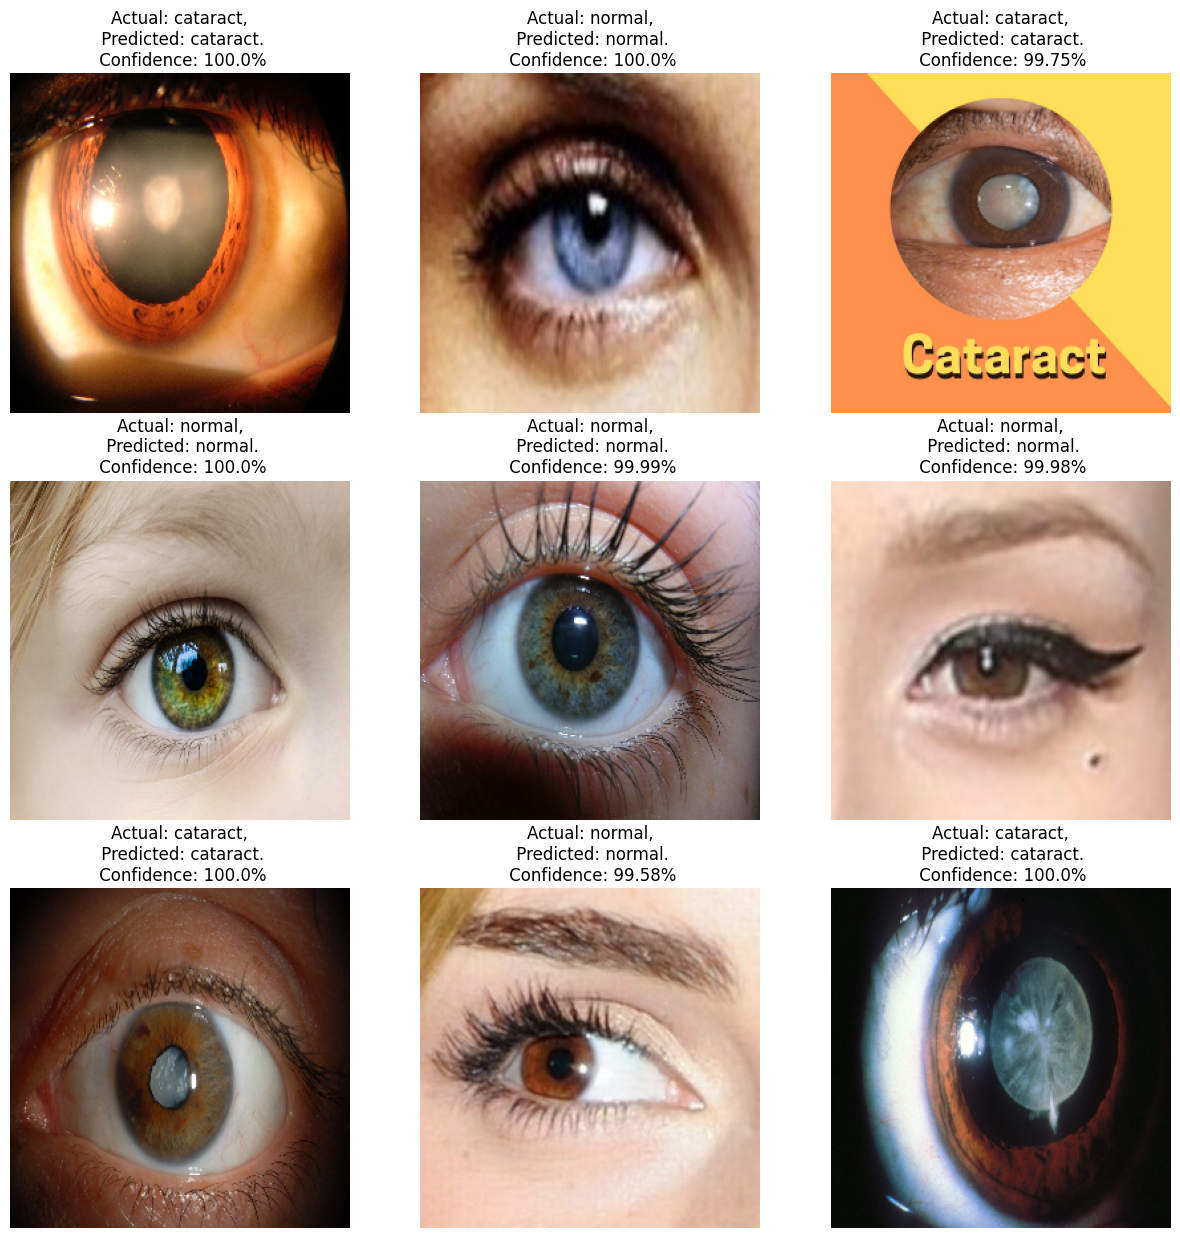

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the model

In [42]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [43]:
from tensorflow.keras.models import load_model
model.save("../saved_models/cataract_model.h5")